In [1]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [2]:
data_train = pd.read_csv('dataset/train.csv')
data_test = pd.read_csv('dataset/test.csv')

In [3]:
print(data_train.shape, data_test.shape)

(517754, 14) (172585, 13)


In [4]:
print(data_train.head(5))

   id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1           0.13  
1                       0           

In [5]:
print(data_train.describe())

                  id      num_lanes      curvature    speed_limit  \
count  517754.000000  517754.000000  517754.000000  517754.000000   
mean   258876.500000       2.491511       0.488719      46.112575   
std    149462.849975       1.120434       0.272563      15.788521   
min         0.000000       1.000000       0.000000      25.000000   
25%    129438.250000       1.000000       0.260000      35.000000   
50%    258876.500000       2.000000       0.510000      45.000000   
75%    388314.750000       3.000000       0.710000      60.000000   
max    517753.000000       4.000000       1.000000      70.000000   

       num_reported_accidents  accident_risk  
count           517754.000000  517754.000000  
mean                 1.187970       0.352377  
std                  0.895961       0.166417  
min                  0.000000       0.000000  
25%                  1.000000       0.230000  
50%                  1.000000       0.340000  
75%                  2.000000       0.460000  
ma

In [6]:
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [7]:
#unique values in incident_train dataset
for col in data_train.columns:
    print(f"{col}: {data_train[col].nunique()}")

id: 517754
road_type: 3
num_lanes: 4
curvature: 261
speed_limit: 5
lighting: 3
weather: 3
road_signs_present: 2
public_road: 2
time_of_day: 3
holiday: 2
school_season: 2
num_reported_accidents: 8
accident_risk: 98


In [8]:
# Get Boolean column
bool_cols = data_train.select_dtypes(include='bool').columns

# Encode boolean column
for col in bool_cols:
    data_train[col] = data_train[col].astype(int)

print(bool_cols)

Index(['road_signs_present', 'public_road', 'holiday', 'school_season'], dtype='object')


In [9]:
# One Hot Encoding
from sklearn.preprocessing import OneHotEncoder

categorical_cols = data_train.select_dtypes(include='object').columns
print(categorical_cols)

Index(['road_type', 'lighting', 'weather', 'time_of_day'], dtype='object')


In [10]:
# Create OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform
encoded = encoder.fit_transform(data_train[categorical_cols])

# Convert encoded data to DataFrame
encoded_data_train = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Gộp lại vào dataframe gốc (nếu muốn giữ numerical features khác)
data_train_encoded = pd.concat([data_train, encoded_data_train], axis=1).drop(columns=categorical_cols)

print(data_train_encoded.head())


   id  num_lanes  curvature  speed_limit  road_signs_present  public_road  \
0   0          2       0.06           35                   0            1   
1   1          4       0.99           35                   1            0   
2   2          4       0.63           70                   0            1   
3   3          4       0.07           35                   1            1   
4   4          1       0.58           60                   0            0   

   holiday  school_season  num_reported_accidents  accident_risk  ...  \
0        0              1                       1           0.13  ...   
1        1              1                       0           0.35  ...   
2        1              0                       2           0.30  ...   
3        0              0                       1           0.21  ...   
4        1              0                       1           0.56  ...   

   road_type_urban  lighting_daylight  lighting_dim  lighting_night  \
0              1.0         

In [11]:
print(data_train_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   road_signs_present      517754 non-null  int64  
 5   public_road             517754 non-null  int64  
 6   holiday                 517754 non-null  int64  
 7   school_season           517754 non-null  int64  
 8   num_reported_accidents  517754 non-null  int64  
 9   accident_risk           517754 non-null  float64
 10  road_type_highway       517754 non-null  float64
 11  road_type_rural         517754 non-null  float64
 12  road_type_urban         517754 non-null  float64
 13  lighting_daylight       517754 non-null  float64
 14  lighting_dim        

In [12]:
print(data_train_encoded.columns)

Index(['id', 'num_lanes', 'curvature', 'speed_limit', 'road_signs_present',
       'public_road', 'holiday', 'school_season', 'num_reported_accidents',
       'accident_risk', 'road_type_highway', 'road_type_rural',
       'road_type_urban', 'lighting_daylight', 'lighting_dim',
       'lighting_night', 'weather_clear', 'weather_foggy', 'weather_rainy',
       'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning'],
      dtype='object')


In [13]:
print(data_train_encoded.head(5))

   id  num_lanes  curvature  speed_limit  road_signs_present  public_road  \
0   0          2       0.06           35                   0            1   
1   1          4       0.99           35                   1            0   
2   2          4       0.63           70                   0            1   
3   3          4       0.07           35                   1            1   
4   4          1       0.58           60                   0            0   

   holiday  school_season  num_reported_accidents  accident_risk  ...  \
0        0              1                       1           0.13  ...   
1        1              1                       0           0.35  ...   
2        1              0                       2           0.30  ...   
3        0              0                       1           0.21  ...   
4        1              0                       1           0.56  ...   

   road_type_urban  lighting_daylight  lighting_dim  lighting_night  \
0              1.0         

In [14]:
# Drop column id
data_train_encoded = data_train_encoded.drop(columns=['id'], axis=1)

# Data Exploration

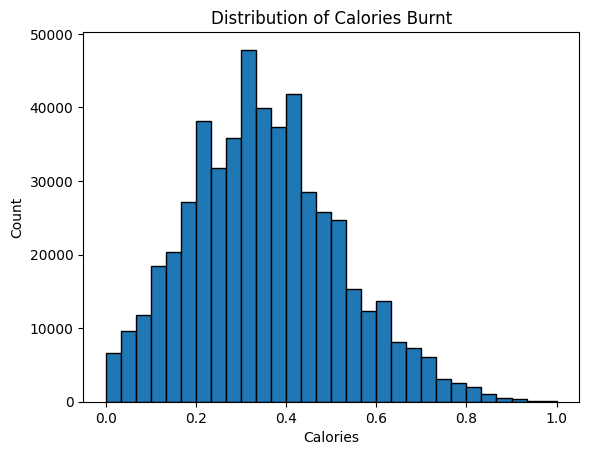

In [15]:
# Plot histogram for the target variable (Calorie burnt)
plt.hist(data_train['accident_risk'], bins=30, edgecolor='k')
plt.title('Distribution of Calories Burnt')
plt.xlabel('Calories')
plt.ylabel('Count')
plt.show()

<Axes: >

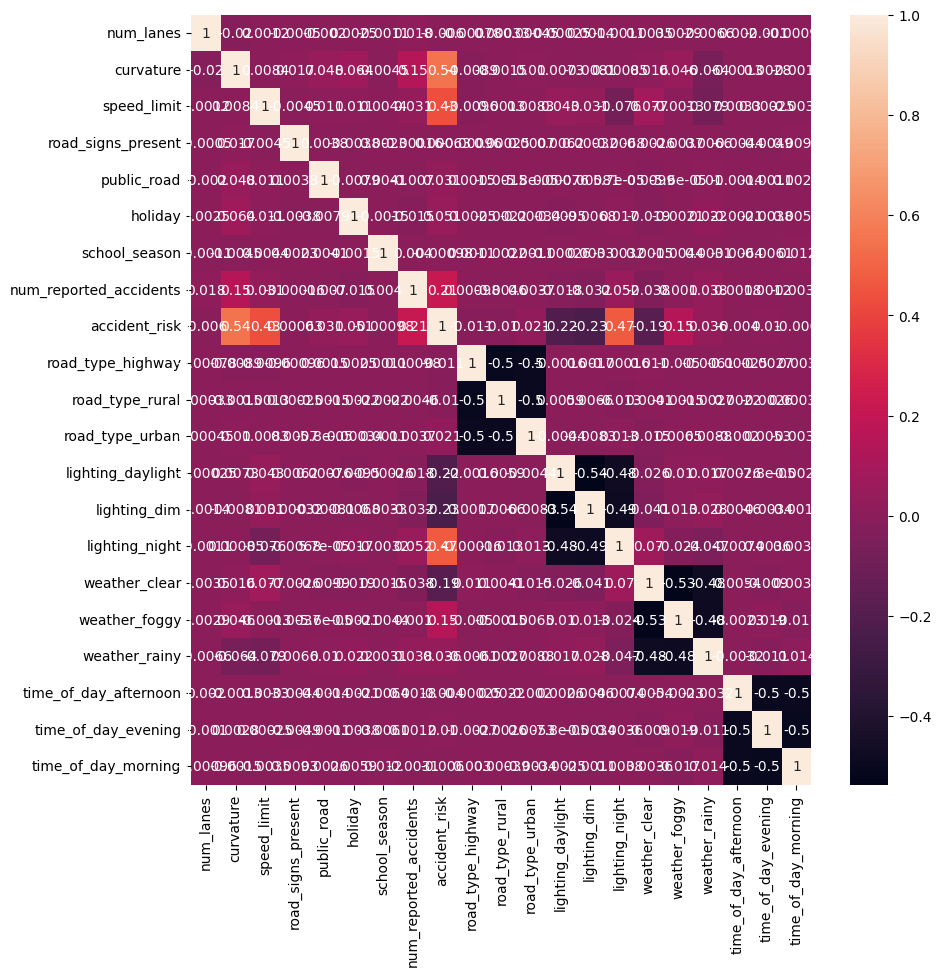

In [16]:
# Exploration correlation
plt.figure(figsize= (10, 10))
sns.heatmap(data_train_encoded.corr(), annot=True)

The correlation table reflects that weather_clear/foggy, lighting_night and num_reported_accidents are correlated with accident_risk

Scatterplot example visualization

In [17]:
# Pairplot
#sns.pairplot(data_train_encoded)

# Transform Data and Data Loader

In [18]:
# Check columns of dataset
data_train_encoded.columns

Index(['num_lanes', 'curvature', 'speed_limit', 'road_signs_present',
       'public_road', 'holiday', 'school_season', 'num_reported_accidents',
       'accident_risk', 'road_type_highway', 'road_type_rural',
       'road_type_urban', 'lighting_daylight', 'lighting_dim',
       'lighting_night', 'weather_clear', 'weather_foggy', 'weather_rainy',
       'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning'],
      dtype='object')

In [20]:
# Separate features and targets
X = data_train_encoded.drop(columns=['accident_risk'], axis=1).values
y = data_train_encoded['accident_risk'].values

print(X.shape, y.shape)

(517754, 20) (517754,)


In [21]:
from sklearn.preprocessing import StandardScaler
# Standardize inputs 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [22]:
# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.reshape(-1,1), dtype=torch.float32)

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([414203, 20]) torch.Size([414203, 1])
torch.Size([103551, 20]) torch.Size([103551, 1])


In [24]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [25]:
batch_size = 32
# Data Loader 
train_loader = DataLoader(train_data, batch_size)
test_loader = DataLoader(test_data, batch_size)

# Model Architecture

In [26]:
input_size = X.shape[1]
print(input_size)

20


In [27]:
# Custom MLP class for regression
class MLPModel(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=16, output_size=1):
        super(MLPModel, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)  # First hidden layer
        self.relu = nn.ReLU()                          # Activation
        self.fc2 = nn.Linear(hidden_size, output_size) # Output layer
    
    def forward(self, x):
        x = self.fc1(x)   # Apply first linear layer
        x = self.relu(x)  # Apply ReLU activation
        x = self.fc2(x)   # Apply output layer
        return x

# Create model instance
model = MLPModel()
print(model)

MLPModel(
  (fc1): Linear(in_features=20, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


# Training loop

In [28]:
# Hyper parameters
model = MLPModel()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [29]:
num_epochs = 300 

# List to store loss values per epoch
train_losses = []

# Training loop
for epoch in range(num_epochs):
    # Forward Pass
    y_pred = model(X_train)

    # Compute Loss
    loss = criterion(y_pred, y_train)

    # Backward Pass
    loss.backward()

    # Optimizer
    optimizer.step()

    # Zero gradients
    optimizer.zero_grad()

    # Append loss
    train_losses.append(loss.item())

    # Print
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [50/300], Loss: 0.0094
Epoch [100/300], Loss: 0.0060
Epoch [150/300], Loss: 0.0053
Epoch [200/300], Loss: 0.0048
Epoch [250/300], Loss: 0.0046
Epoch [300/300], Loss: 0.0045


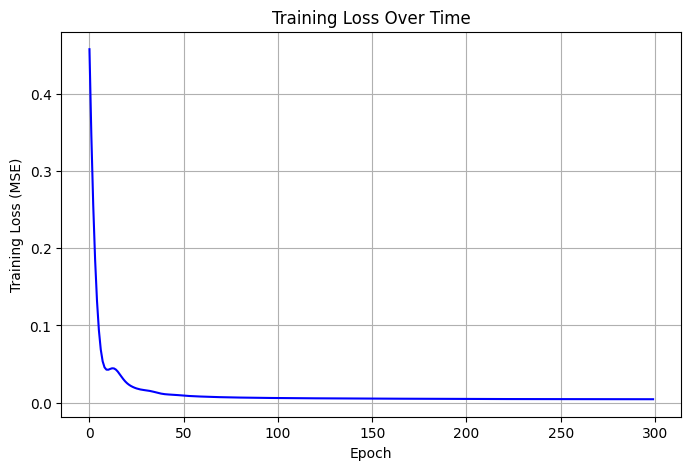

In [30]:
import matplotlib.pyplot as plt

# Plot the training loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), train_losses, linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

Great!!!! The training loss over time is quite good! 

# Evaluation

In [34]:
# Evaluate model performance

with torch.no_grad():
    # Predict on train set
    train_preds = model(X_train)
    train_loss = criterion(train_preds, y_train)

    # Predict on test set
    test_preds = model(X_test)
    test_loss = criterion(test_preds, y_test)

print(f"Final Training Loss (MSE): {train_loss.item():.4f}")
print(f"Final Testing Loss (MSE): {test_loss.item():.4f}")


Final Training Loss (MSE): 0.0045
Final Testing Loss (MSE): 0.0045


In [35]:
# Calculate RMSE
train_rmse = torch.sqrt(train_loss)
test_rmse = torch.sqrt(test_loss)

print(f"Training RMSE: {train_rmse.item():.2f}")
print(f"Testing RMSE: {test_rmse.item():.2f}")

Training RMSE: 0.07
Testing RMSE: 0.07


# Get Prediction with file test.csv

In [36]:
# Load new dataset
data_test = pd.read_csv("dataset/test.csv")
print(data_test.head(5))

       id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0  517754   highway          2       0.34           45     night   clear   
1  517755     urban          3       0.04           45       dim   foggy   
2  517756     urban          2       0.59           35       dim   clear   
3  517757     rural          4       0.95           35  daylight   rainy   
4  517758   highway          2       0.86           35  daylight   clear   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0                True         True   afternoon     True           True   
1                True        False   afternoon     True          False   
2                True        False   afternoon     True           True   
3               False        False   afternoon    False          False   
4                True        False     evening    False           True   

   num_reported_accidents  
0                       1  
1                       0  
2             

In [37]:
print(data_test.shape)

(172585, 13)


In [38]:
# Encode
# Get Boolean column
bool_cols = data_test.select_dtypes(include='bool').columns

# Encode boolean column
for col in bool_cols:
    data_test[col] = data_test[col].astype(int)

print(bool_cols)

Index(['road_signs_present', 'public_road', 'holiday', 'school_season'], dtype='object')


In [39]:
# One Hot Encoding
from sklearn.preprocessing import OneHotEncoder

categorical_cols = data_test.select_dtypes(include='object').columns
print(categorical_cols)

# Create OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform
encoded = encoder.fit_transform(data_test[categorical_cols])

# Convert encoded data to DataFrame
encoded_data_test = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Gộp lại vào dataframe gốc (nếu muốn giữ numerical features khác)
data_test_encoded = pd.concat([data_test, encoded_data_test], axis=1).drop(columns=categorical_cols)

print(data_test_encoded.head())

Index(['road_type', 'lighting', 'weather', 'time_of_day'], dtype='object')
       id  num_lanes  curvature  speed_limit  road_signs_present  public_road  \
0  517754          2       0.34           45                   1            1   
1  517755          3       0.04           45                   1            0   
2  517756          2       0.59           35                   1            0   
3  517757          4       0.95           35                   0            0   
4  517758          2       0.86           35                   1            0   

   holiday  school_season  num_reported_accidents  road_type_highway  ...  \
0        1              1                       1                1.0  ...   
1        1              0                       0                0.0  ...   
2        1              1                       1                0.0  ...   
3        0              0                       2                0.0  ...   
4        0              1                       3    

In [40]:
data_test_encoded = data_test_encoded.drop(columns=["id"])

# Scale features using same scaler
new_X_scaled = scaler.transform(data_test_encoded)

# Convert to tensor
new_X_tensor = torch.tensor(new_X_scaled, dtype=torch.float32)

# Predict
model.eval()
with torch.no_grad():
    pred_accident_risk = model(new_X_tensor).numpy()

# Add prediction to DataFrame
data_test_encoded["accident_risk"] = pred_accident_risk #Column Calories is predicted calories
print(data_test_encoded.head())


   num_lanes  curvature  speed_limit  road_signs_present  public_road  \
0          2       0.34           45                   1            1   
1          3       0.04           45                   1            0   
2          2       0.59           35                   1            0   
3          4       0.95           35                   0            0   
4          2       0.86           35                   1            0   

   holiday  school_season  num_reported_accidents  road_type_highway  \
0        1              1                       1                1.0   
1        1              0                       0                0.0   
2        1              1                       1                0.0   
3        0              0                       2                0.0   
4        0              1                       3                1.0   

   road_type_rural  ...  lighting_daylight  lighting_dim  lighting_night  \
0              0.0  ...                0.0          

/Users/phuongnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [41]:
print(data_test_encoded.shape)

(172585, 21)


In [42]:
# Load original test dataset
test_original = pd.read_csv("dataset/test.csv")

In [43]:
sample_submission = pd.concat([test_original[["id"]], data_test_encoded[["accident_risk"]]], axis=1)

print(sample_submission.head())

       id  accident_risk
0  517754       0.306059
1  517755       0.126653
2  517756       0.189498
3  517757       0.409263
4  517758       0.340628


In [44]:
# Export file csv for sample_submission_calories
sample_submission.to_csv('dataset/kaggle_ss5ep10_accidentrisk_sample_submission.csv', index=False)